# Capstone Presentation - Supervised Learning Models - TikTok

# Column Description  

| Column Name             | Description                                                                                             | Possible Values                                                                 |
|--------------------------|---------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------|
| **id**                  | TikTok-assigned unique number for identifying each video containing a claim or opinion.                | Numeric                                                                         |
| **claim_status**        | Indicates whether the video is classified as an “opinion” or a “claim”.                                | `opinion`, `claim`                                                             |
| **video_id**            | A randomly assigned identifier for the video upon publication on TikTok.                               | Alphanumeric                                                                   |
| **video_duration_sec**  | The duration of the published video, measured in seconds.                                              | Numeric                                                                         |
| **video_transcription_text** | The transcribed text of the words spoken in the published video.                                     | Text                                                                           |
| **verified_status**     | Indicates the TikTok user's verification status.                                                       | `verified`, `not verified`                                                     |
| **author_ban_status**   | Indicates the permissions status of the TikTok user who published the video.                           | `active`, `under scrutiny`, `banned`                                           |
| **video_view_count**    | The total number of views the published video has received.                                             | Numeric                                                                         |
| **video_like_count**    | The total number of likes the published video has received.                                             | Numeric                                                                         |
| **video_share_count**   | The total number of times the published video has been shared by other users.                          | Numeric                                                                         |
| **video_download_count**| The total number of times the published video has been downloaded by other users.                      | Numeric                                                                         |
| **video_comment_count** | The total number of comments on the published video.                                                   | Numeric                                                                         |


## 1. Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.datasets import make_classification

from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
import textwrap

import spacy
from collections import Counter

## 2. Load dataset as pandas dataframe

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("murilozangari/tiktok-claim-analysis")

print("Path to dataset files:", path)

100%|██████████| 794k/794k [00:00<00:00, 24.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/murilozangari/tiktok-claim-analysis/versions/2


In [3]:
# df = pd.read_csv('tiktok_claims.csv')
df = pd.read_csv(path + '/tiktok_claims.csv')

## 3. Explore dataframe

In [4]:
df.shape

(19382, 12)

In [5]:
num_duplicates = df[df.duplicated()].shape[0]
print("Number of duplicate rows:", num_duplicates)

Number of duplicate rows: 0


In [6]:
(df.head())

,id,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [7]:
(df.tail())

,id,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
19377,19378,NaN,7578226840,21,NaN,not verified,active,NaN,NaN,NaN,NaN,NaN
19378,19379,NaN,6079236179,53,NaN,not verified,active,NaN,NaN,NaN,NaN,NaN
19379,19380,NaN,2565539685,10,NaN,verified,under review,NaN,NaN,NaN,NaN,NaN
19380,19381,NaN,2969178540,24,NaN,not verified,active,NaN,NaN,NaN,NaN,NaN
19381,19382,NaN,8132759688,13,NaN,not verified,active,NaN,NaN,NaN,NaN,NaN


In [8]:
df.nunique()

,0
id,19382
claim_status,2
video_id,19382
video_duration_sec,56
video_transcription_text,19012
verified_status,2
author_ban_status,3
video_view_count,15632
video_like_count,12224
video_share_count,9231


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [10]:
df.isnull().sum()

,0
id,0
claim_status,298
video_id,0
video_duration_sec,0
video_transcription_text,298
verified_status,0
author_ban_status,0
video_view_count,298
video_like_count,298
video_share_count,298


In [11]:
df = df.dropna()

In [12]:
df.isnull().sum()

,0
id,0
claim_status,0
video_id,0
video_duration_sec,0
video_transcription_text,0
verified_status,0
author_ban_status,0
video_view_count,0
video_like_count,0
video_share_count,0


In [13]:
nan_mask = df.isna()
has_nan = df.isna().any().any()

In [14]:
df.columns

Index(['id', 'claim_status', 'video_id', 'video_duration_sec',
       'video_transcription_text', 'verified_status', 'author_ban_status',
       'video_view_count', 'video_like_count', 'video_share_count',
       'video_download_count', 'video_comment_count'],
      dtype='object')

In [15]:
df["verified_status"].value_counts(normalize=True)

,proportion
verified_status,
not verified,0.93712
verified,0.06288


## 4. EDA

### 4.1 Display transcription for claim and opinion text

In [16]:
# Define first ROWS of video transcription text fordisplay
ROWS=30

In [17]:
text = df.loc[df['claim_status'] == "opinion", 'video_transcription_text'][:ROWS].str.cat(sep='....')

# Wrap the text for better readability
wrapped_text= textwrap.fill(text, width=80)

# Print the wrapped review
print("Here are the transcriptions for opinion:")
print(wrapped_text)

Here are the transcriptions for opinion:
i think that humans will live on mars by 2035....i think that we will all fly
with individual jetpacks by 2032....i think that drone deliveries are already
happening and will become common by 2025....i think that there are more
microorganisms in one teaspoon of soil than people on the planet....i think that
dubai is an island created by humans....i think that yellowstone national park
is home to a supervolcano....i think that 20% of the world's oxygen is produced
in the amazon jungles....i think that there are about 582 million entrepreneurs
in the world....i think that seventy percent of small businesses are owned and
operated by a single person.....i think that 90% of goods are shipped by ocean
freight....i think that mobile phone use in india is nearly 100%....i think that
the total number of multinational companies investing in green initiatives has
increased by 35% since 2020....i think that it would take less than a month to
get to the moo

An “opinion” refers to an individual's or group's personal belief or thought.

In [18]:
text = df.loc[df['claim_status'] == "claim", 'video_transcription_text'][:ROWS].str.cat(sep='....')

# Wrap the text for better readability
wrapped_text= textwrap.fill(text, width=80)  # Adjust width as needed

# Print the wrapped review
print("Here are the transcriptions for claims:")
print(wrapped_text)

Here are the transcriptions for claims:
someone shared with me that drone deliveries are already happening and will
become common by 2025....someone shared with me that there are more
microorganisms in one teaspoon of soil than people on the planet....someone
shared with me that american industrialist andrew carnegie had a net worth of
$475 million usd, worth over $300 billion usd today....someone shared with me
that the metro of st. petersburg, with an average depth of hundred meters, is
the deepest metro in the world....someone shared with me that the number of
businesses allowing employees to bring pets to the workplace has grown by 6%
worldwide....someone shared with me that gross domestic product (gdp) is the
best financial indicator of a country's overall trade potential....someone
shared with me that elvis presley has sold more records than the music band the
beatles....someone shared with me that the best selling single of all time is
"white christmas" by bing crosby....someone

A “claim” refers to information that is either unsourced or from a unverified source.

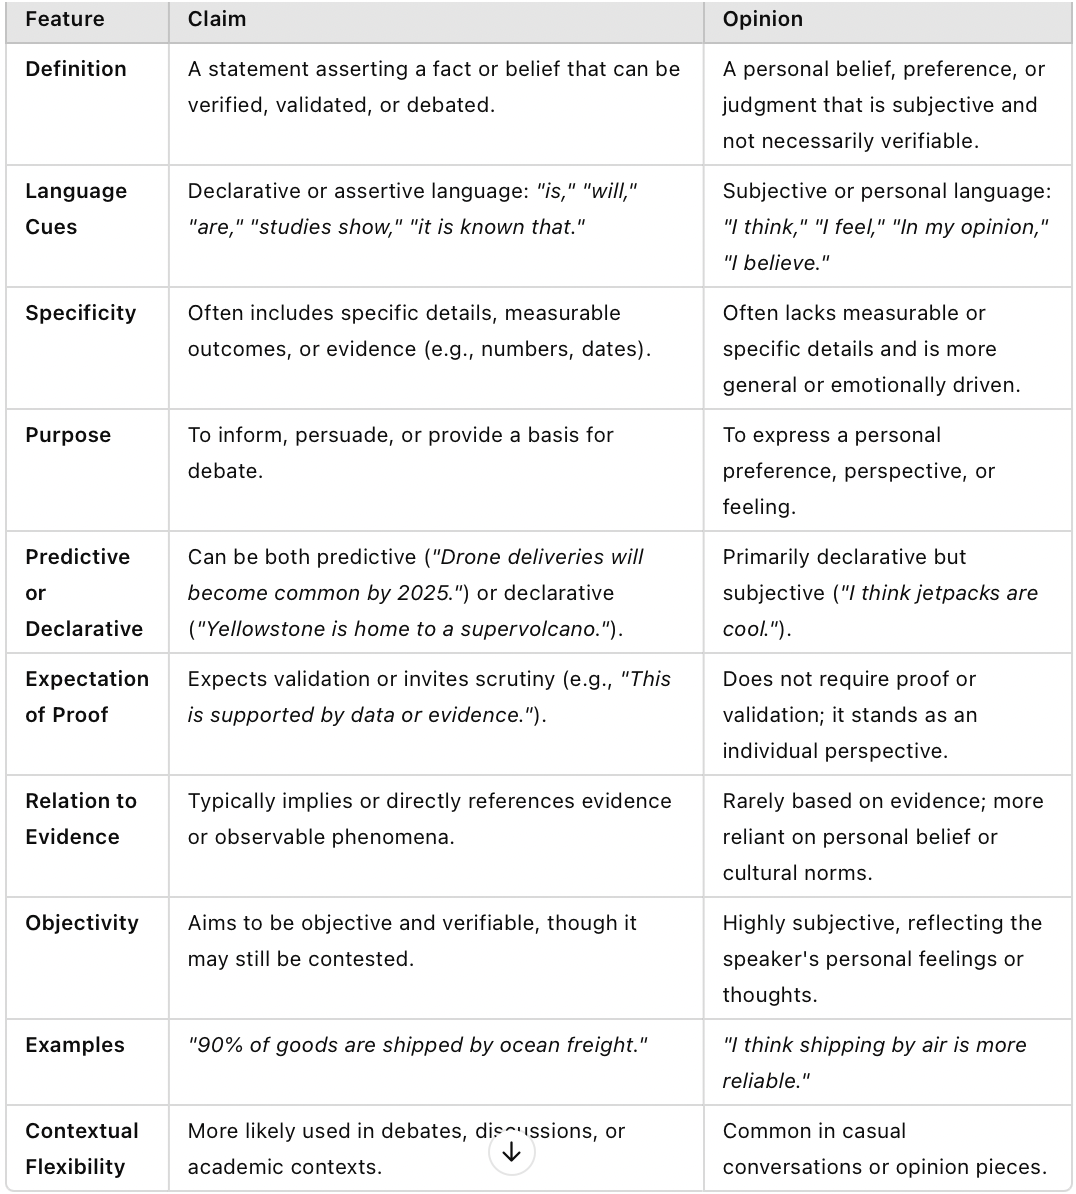

### 4.2 Word Cloud visualization for `video_transcription_text`

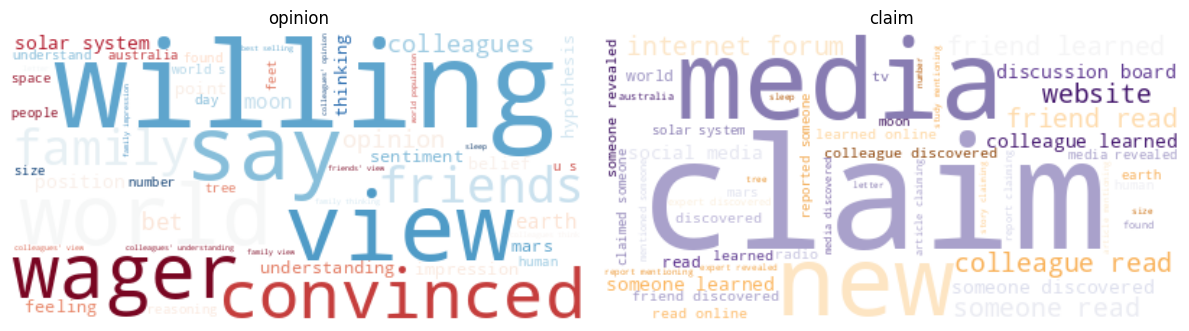

CPU times: user 2.05 s, sys: 127 ms, total: 2.18 s
Wall time: 4.17 s


<Figure size 640x480 with 0 Axes>

In [19]:
%%time

# Create subplots for visualizing word clouds
fig, ax = plt.subplots(1, 2, figsize=(12, 10))

# Sentiment categories
labels = { 0: "opinion", 1: "claim" }
colormap_list = ["RdBu", "PuOr"]

# Generate word clouds for each sentiment in a loop
for i, (key, label) in enumerate(labels.items()):
    reviews = df.loc[df['claim_status'] == label, 'video_transcription_text'].str.cat(sep=' ')
    word_cloud = WordCloud(max_words=50, normalize_plurals=True,
                           colormap=colormap_list[i], background_color='white').generate(reviews)

    # Save word cloud to a file
    word_cloud.to_file(f"word_cloud_{label}.png")

    ax[i].imshow(word_cloud, interpolation='bilinear')
    ax[i].axis('off')
    ax[i].set_title(label)

plt.tight_layout()
plt.show()
plt.savefig("wordclouds.png")

In [20]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

{0: 'opinion', 1: 'claim'}
opinion
claim


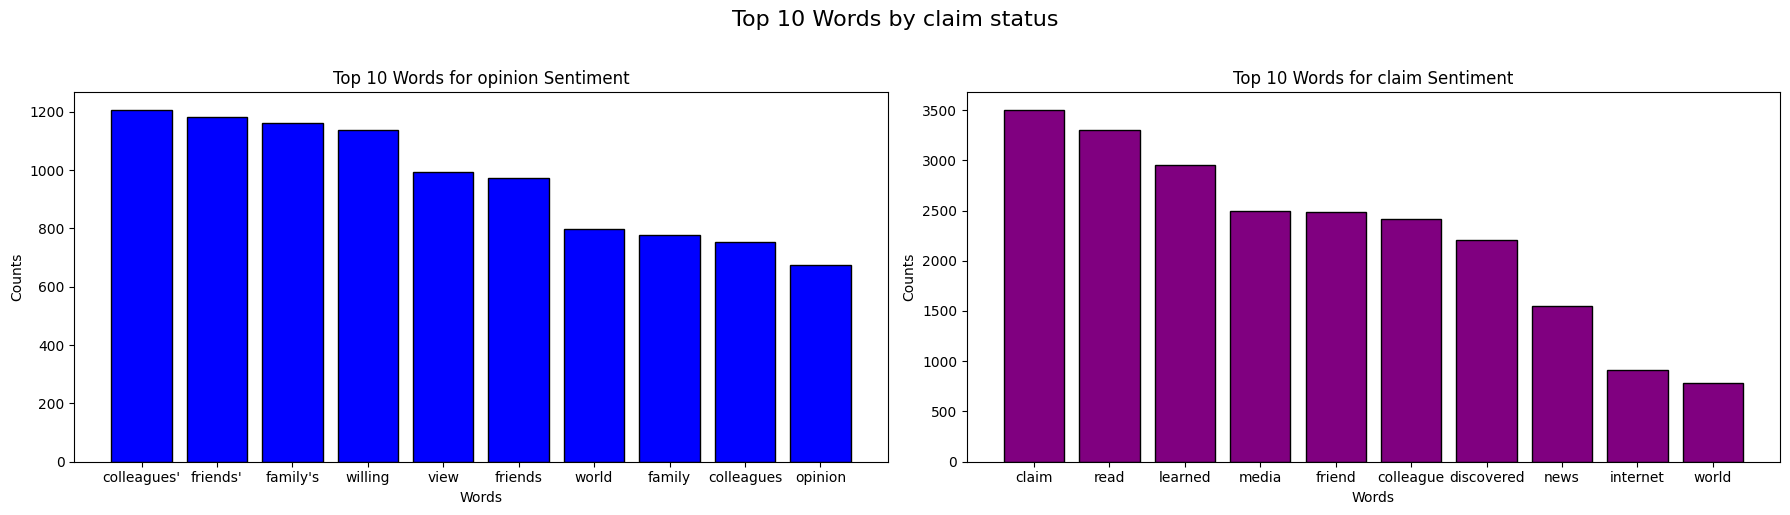

In [21]:
# Plot top n words for filtered positive and negative text
def plot_top_n_words_filtered(df, labels=[0, 1], n=5, text_column='video_transcription_text'):
    colour_list = ['blue', 'purple']
    label_dict = dict(zip(labels, ["opinion", "claim"]))
    print(label_dict)

    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(18, 5))  # Two subplots side-by-side

    for idx, label in label_dict.items():
        print(label)
        filtered_text = df[df['claim_status'] == label][text_column]

        # Tokenize the filtered reviews
        tokens = filtered_text.str.split()

        # Count the frequency of each word
        token_list = tokens.explode().tolist()
        word_counts = Counter([word for word in token_list if word.lower() not in nlp.Defaults.stop_words])

        # Get the top n words and their counts
        top_n_words = word_counts.most_common(n)

        # Separate words and counts for plotting
        words, counts = zip(*top_n_words)

        # Plot the top n words
        ax[idx].bar(words, counts, edgecolor='black', color=colour_list[idx])
        ax[idx].set_title(f"Top {n} Words for {label_dict[idx]} Sentiment")
        ax[idx].set_xlabel('Words')
        ax[idx].set_ylabel('Counts')

    # Adjust layout and show the plot
    plt.suptitle(f'Top {n} Words by claim status', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Ensure df['processed_reviews'] contains processed text and df['sentiment'] contains sentiment labels
plot_top_n_words_filtered(df, n=10)

### 4.3 Main

In [22]:
columns_of_interest = ['video_duration_sec', 'video_view_count', 'video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count']

descriptive_stats = df[columns_of_interest].describe()
(descriptive_stats)

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,32.423811,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,16.226470,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [23]:
df.dtypes

,0
id,int64
claim_status,object
video_id,int64
video_duration_sec,int64
video_transcription_text,object
verified_status,object
author_ban_status,object
video_view_count,float64
video_like_count,float64
video_share_count,float64


In [24]:
numerical_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_df.corr()

(correlation_matrix)

,id,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
id,1.000000,-0.003590,-0.000145,-0.668047,-0.540852,-0.451713,-0.447729,-0.377445
video_id,-0.003590,1.000000,0.008460,0.000217,0.000236,-0.002721,0.002155,0.005336
video_duration_sec,-0.000145,0.008460,1.000000,0.008481,0.011567,0.011560,0.013078,0.000615
video_view_count,-0.668047,0.000217,0.008481,1.000000,0.804322,0.665635,0.664222,0.554172
video_like_count,-0.540852,0.000236,0.011567,0.804322,1.000000,0.825789,0.823554,0.687185
video_share_count,-0.451713,-0.002721,0.011560,0.665635,0.825789,1.000000,0.679910,0.574632
video_download_count,-0.447729,0.002155,0.013078,0.664222,0.823554,0.679910,1.000000,0.832464
video_comment_count,-0.377445,0.005336,0.000615,0.554172,0.687185,0.574632,0.832464,1.000000


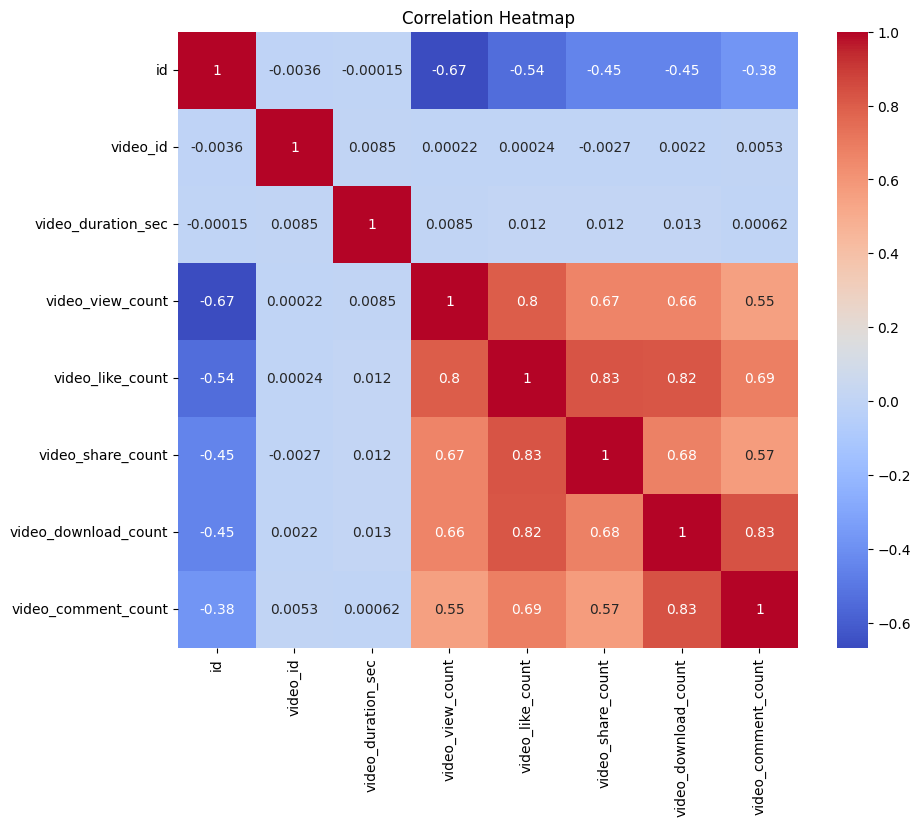

In [25]:
# Correlation Heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [26]:
df

,id,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19079,19080,opinion,1492320297,49,in our opinion the earth holds about 11 quinti...,not verified,active,6067.0,423.0,81.0,8.0,2.0
19080,19081,opinion,9841347807,23,in our opinion the queens in ant colonies live...,not verified,active,2973.0,820.0,70.0,3.0,0.0
19081,19082,opinion,8024379946,50,in our opinion the moon is moving away from th...,not verified,active,734.0,102.0,7.0,2.0,1.0
19082,19083,opinion,7425795014,8,in our opinion lightning strikes somewhere on ...,not verified,active,3394.0,655.0,123.0,11.0,4.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19084 entries, 0 to 19083
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        19084 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19084 non-null  int64  
 3   video_duration_sec        19084 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19084 non-null  object 
 6   author_ban_status         19084 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.9+ MB


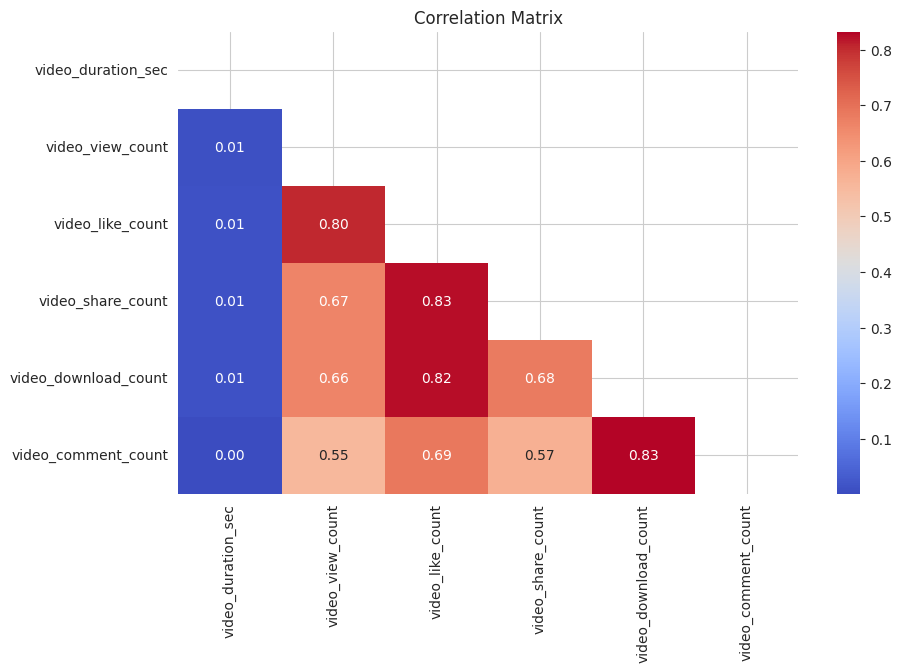

In [28]:
# Correlation Matrix

# Select only numeric columns
numeric_df = df.select_dtypes(include=['number']).drop(columns=["id", "video_id"])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Correlation Matrix')
plt.show()

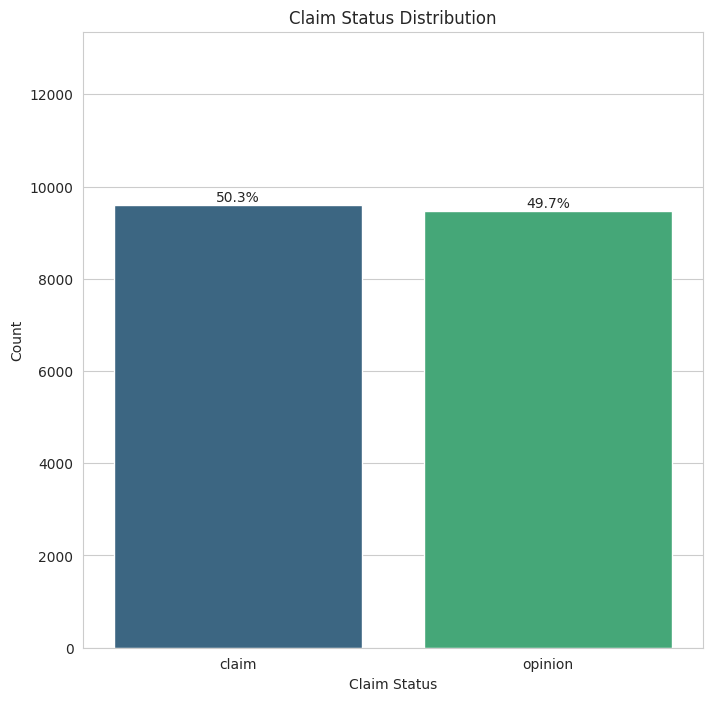

In [29]:
# Target Variable = Claim Status

# Bar plot
plt.figure(figsize=(8, 8))
sns.countplot(data=df, x='claim_status', palette='viridis')

# Add percentage labels
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2, height, f'{height / len(df):.1%}', ha='center', va='bottom')

plt.title('Claim Status Distribution')
plt.xlabel('Claim Status')
plt.ylabel('Count')
plt.ylim(0, len(df) * 0.7)
plt.show()

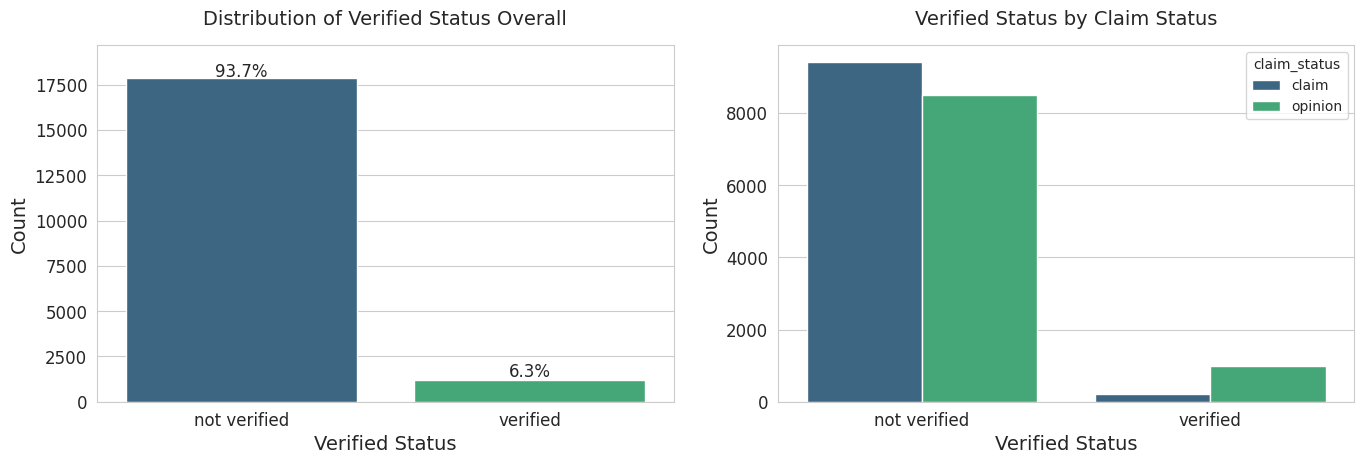

In [30]:
# Analysing verified_status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribution of verified_status
sns.countplot(data=df, x='verified_status', palette='viridis', ax=axes[0])

# Add percentage labels on top of each bar
for p in axes[0].patches:
    height = p.get_height()
    if height > 0:
        axes[0].text(p.get_x() + p.get_width() / 2, height * 0.99,
                     f'{height / len(df):.1%}', ha='center', va='bottom', fontsize=12)

axes[0].set_title('Distribution of Verified Status Overall', fontsize=14, pad=15)
axes[0].set_xlabel('Verified Status', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].set_ylim(0, max([p.get_height() for p in axes[0].patches]) * 1.1)  # Add a 10% buffer to fit labels

# Plot 2: Claims by verification status
sns.countplot(data=df, x='verified_status', hue='claim_status', palette='viridis', ax=axes[1])

axes[1].set_title('Verified Status by Claim Status', fontsize=14, pad=15)
axes[1].set_xlabel('Verified Status', fontsize=14)
axes[1].set_ylabel('Count', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout(pad=2)
plt.show()

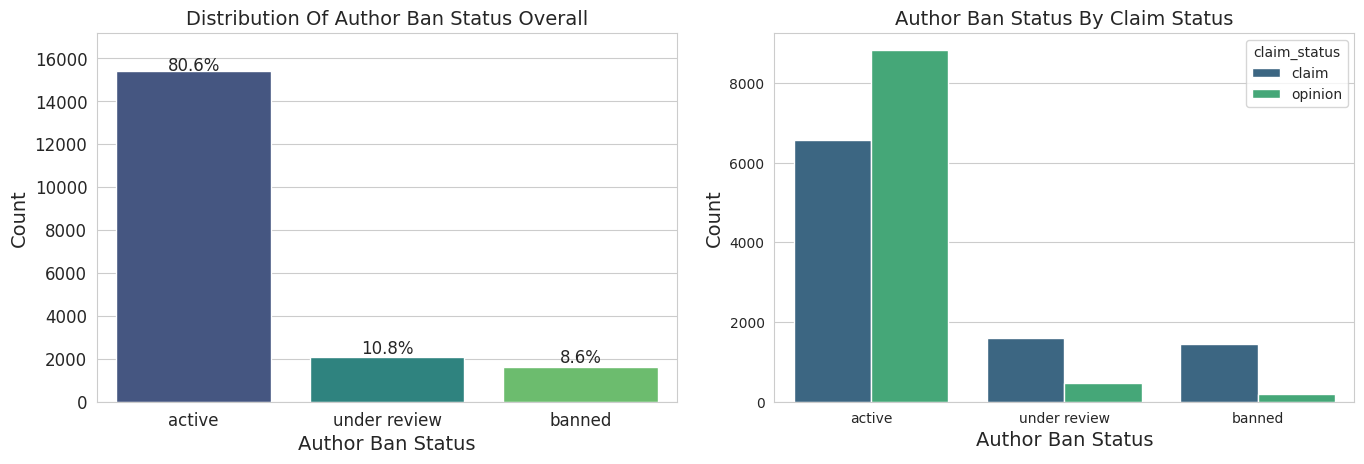

In [31]:
# Analysing author_ban_status

# Convert 'author_ban_status' to a categorical variable
df['author_ban_status'] = pd.Categorical(df['author_ban_status'], categories=['active', 'under review', 'banned'], ordered=True)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribution of author ban status overall
sns.countplot(data=df, x='author_ban_status', palette='viridis', ax=axes[0])

# Add percentage labels on top of each bar
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2, height * 0.99, f'{height / len(df):.1%}',
                 ha='center', va='bottom', fontsize=12)

axes[0].set_title('Distribution Of Author Ban Status Overall', fontsize=14)
axes[0].set_xlabel('Author Ban Status', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].set_ylim(0, len(df) * 0.9)

# Plot 2: Claim Status by Author Ban Status
sns.countplot(data=df, x='author_ban_status', hue='claim_status', palette='viridis', ax=axes[1])
axes[1].set_title('Author Ban Status By Claim Status', fontsize=14)
axes[1].set_xlabel('Author Ban Status', fontsize=14)
axes[1].set_ylabel('Count', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout(pad=2)
plt.show()

In [32]:
grouped_data = df.groupby(['claim_status']).agg({'video_view_count': ['mean', 'std', 'median']}).reset_index()
(grouped_data)

claim_status video_view_count                         
                           mean            std    median
0        claim    501029.452748  291349.239825  501555.0
1      opinion      4956.432250    2885.907219    4953.0

In [33]:
df = df.drop(['id', 'video_id'], axis=1)

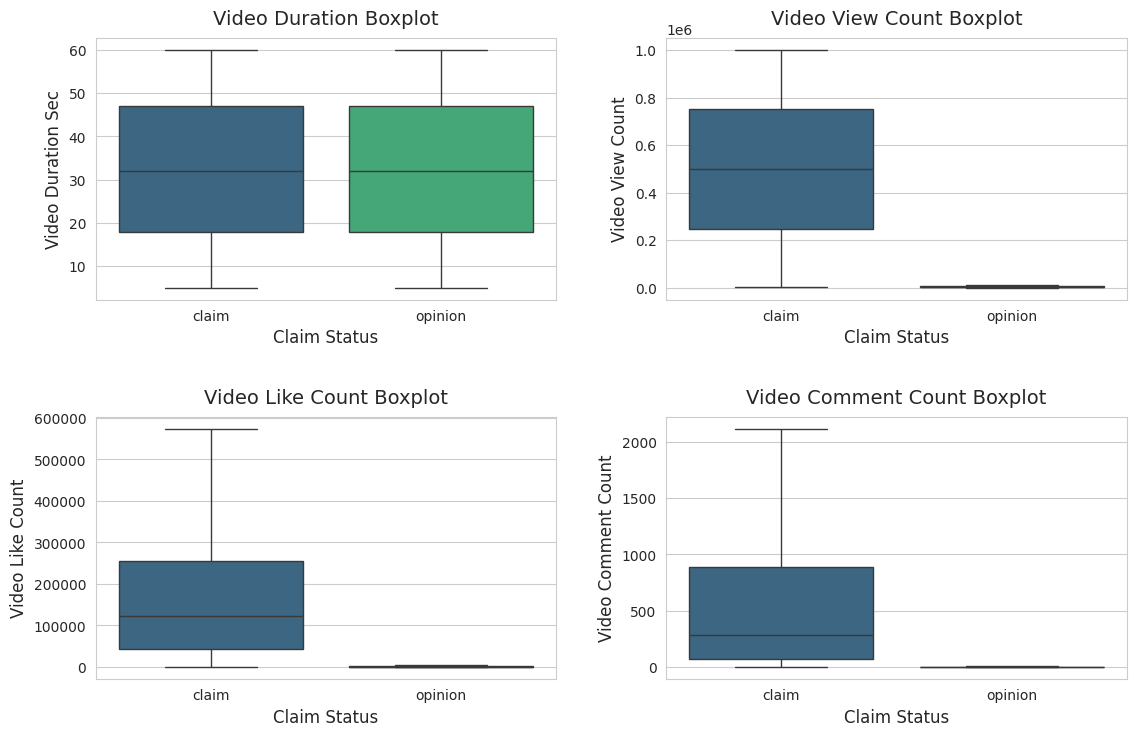

In [34]:
# Set style
sns.set_style("whitegrid")

# Define figure and axes
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# List of variables to plot and their respective axes
plot_vars = [
    ('video_duration_sec', 'Video Duration'),
    ('video_view_count', 'Video View Count'),
    ('video_like_count', 'Video Like Count'),
    ('video_comment_count', 'Video Comment Count')
]

# Loop through the variables and axes to create boxplots
for ax, (var, title) in zip(axs.flat, plot_vars):
    sns.boxplot(data=df, y=var, x='claim_status', palette='viridis', ax=ax, showfliers=False)
    ax.set_title(f'{title} Boxplot', fontsize=14, pad=10)
    ax.set_xlabel('Claim Status', fontsize=12)
    ax.set_ylabel(var.replace('_', ' ').title(), fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout to prevent overlap
plt.tight_layout(pad=3)
plt.show()

## 5. Feature Selection

In [35]:
# where opinion = 0 and claim = 1

# Create a copy of the dataframe to avoid modifying the original
X = df.copy()

# Encode the target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})

# Drop the target variable from the feature set
X = X.drop('claim_status', axis=1)

# Dummy encode the categorical columns while avoiding the first level to prevent multicollinearity
# X = pd.get_dummies(X, columns=['verified_status', 'author_ban_status'], drop_first=True)

# Display the transformed data
X.head()

,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [36]:
X["video_transcription_text"] = X["video_transcription_text"].str.lower()

opinion_keywords = ["think", "feel", "opinion", "believe"] # words that likely appear in opinions
claim_keywords = ["shared"] # words that likely appear in claims

opinion_keywords = r"|".join(opinion_keywords)
claim_keywords = r"|".join(claim_keywords)

pattern = opinion_keywords
X["video_opinion_kw_count"] = X["video_transcription_text"].str.count(pattern)
pattern = claim_keywords
X["video_claim_kw_count"] = X["video_transcription_text"].str.count(pattern)

In [37]:
# Feature engineering of the video transcription column
X["video_transcription_len"] = X["video_transcription_text"].str.len()

In [38]:
X

,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,video_opinion_kw_count,video_claim_kw_count,video_transcription_len
0,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0,1,97
1,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0,1,107
2,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0,1,137
3,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,0,1,131
4,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,0,1,128
...,...,...,...,...,...,...,...,...,...,...,...,...
19079,49,in our opinion the earth holds about 11 quinti...,not verified,active,6067.0,423.0,81.0,8.0,2.0,1,0,65
19080,23,in our opinion the queens in ant colonies live...,not verified,active,2973.0,820.0,70.0,3.0,0.0,1,0,66
19081,50,in our opinion the moon is moving away from th...,not verified,active,734.0,102.0,7.0,2.0,1.0,1,0,53
19082,8,in our opinion lightning strikes somewhere on ...,not verified,active,3394.0,655.0,123.0,11.0,4.0,1,0,80


## 6. Train Test Split

In [39]:
# Drop 'video_transcription_text' column from the features
X = X.drop(['video_transcription_text'], axis=1)  # Features (excluding 'video_transcription_text')
y = df['claim_status']  # Target variable

# Convert categorical variables to numeric (Label Encoding or One-Hot Encoding)
# Label Encoding for 'verified_status' and 'author_ban_status'
le_verified = LabelEncoder()
X['verified_status'] = le_verified.fit_transform(X['verified_status'])

le_ban_status = LabelEncoder()
X['author_ban_status'] = le_ban_status.fit_transform(X['author_ban_status'])

# Split the data into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
X_train

,video_duration_sec,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,video_opinion_kw_count,video_claim_kw_count,video_transcription_len
5142,46,0,0,532092.0,269442.0,77939.0,5624.0,28.0,0,0,88
11131,49,0,0,4081.0,1306.0,471.0,31.0,8.0,1,0,83
8374,54,0,0,495598.0,17428.0,5819.0,301.0,10.0,0,0,100
8471,54,0,0,960619.0,7256.0,2331.0,116.0,56.0,0,0,135
13714,48,0,0,7818.0,1932.0,34.0,2.0,0.0,1,0,103
...,...,...,...,...,...,...,...,...,...,...,...
11284,19,0,0,5199.0,963.0,254.0,6.0,1.0,0,0,80
11964,43,0,0,8410.0,1814.0,10.0,5.0,2.0,0,0,79
5390,28,0,0,658519.0,277852.0,70482.0,6227.0,2405.0,0,0,110
860,8,0,0,47460.0,7080.0,2021.0,38.0,9.0,0,0,94


## 7. Modeling

### 7.1 Random Forest Classifier

In [41]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3817 entries, 18920 to 8794
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_duration_sec       3817 non-null   int64  
 1   verified_status          3817 non-null   int64  
 2   author_ban_status        3817 non-null   int64  
 3   video_view_count         3817 non-null   float64
 4   video_like_count         3817 non-null   float64
 5   video_share_count        3817 non-null   float64
 6   video_download_count     3817 non-null   float64
 7   video_comment_count      3817 non-null   float64
 8   video_opinion_kw_count   3817 non-null   int64  
 9   video_claim_kw_count     3817 non-null   int64  
 10  video_transcription_len  3817 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 357.8 KB


In [42]:
# Initialize the RandomForestClassifier (you can use other models)
model = RandomForestClassifier(random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.9948

Confusion Matrix:
[[1910   18]
 [   2 1887]]


In [43]:
import joblib
file_name = 'random_forest_model.joblib'
joblib.dump(model, file_name)

['random_forest_model.joblib']

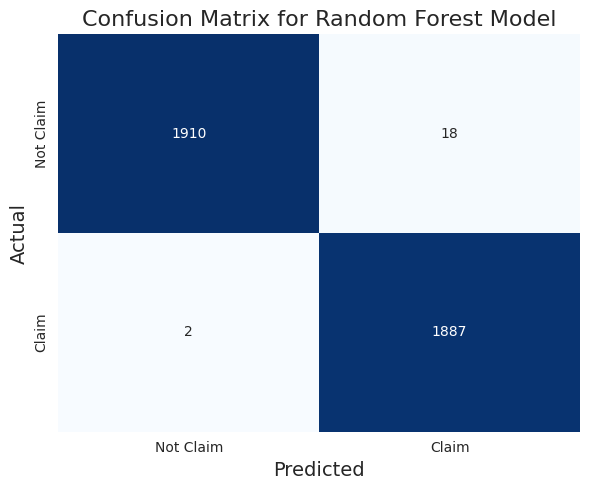

In [44]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Not Claim', 'Claim'], yticklabels=['Not Claim', 'Claim'])


plt.title('Confusion Matrix for Random Forest Model', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.tight_layout()
plt.show()

True Negatives (TN): 1910 – These are the cases where the model correctly predicted not claim (i.e., claim_status = 0)

False Positives (FP): 18 – These are the cases where the model incorrectly predicted claim when the true status was not claim

False Negatives (FN): 1 – These are the cases where the model incorrectly predicted not claim when the true status was claim

True Positives (TP): 1888 – These are the cases where the model correctly predicted claim (i.e., claim_status = 1)

High Accuracy: Model is very accurate overall.

Class Imbalance Handling: The confusion matrix suggests that both classes are predicted well, with very low false positives (18) and false negatives (1).

Precision vs. Recall: The model slightly prioritizes recall (fewer missed positives) over precision (few false alarms).

Balanced Performance: High F1-score indicates good balance between precision and recall

In [45]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

       claim       1.00      0.99      0.99      1928
     opinion       0.99      1.00      0.99      1889

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**The precision for opinion classification is 99%. This means that out of all the predictions where the model classified a report as an opinion, 1% were incorrectly classified and should have been claims.**

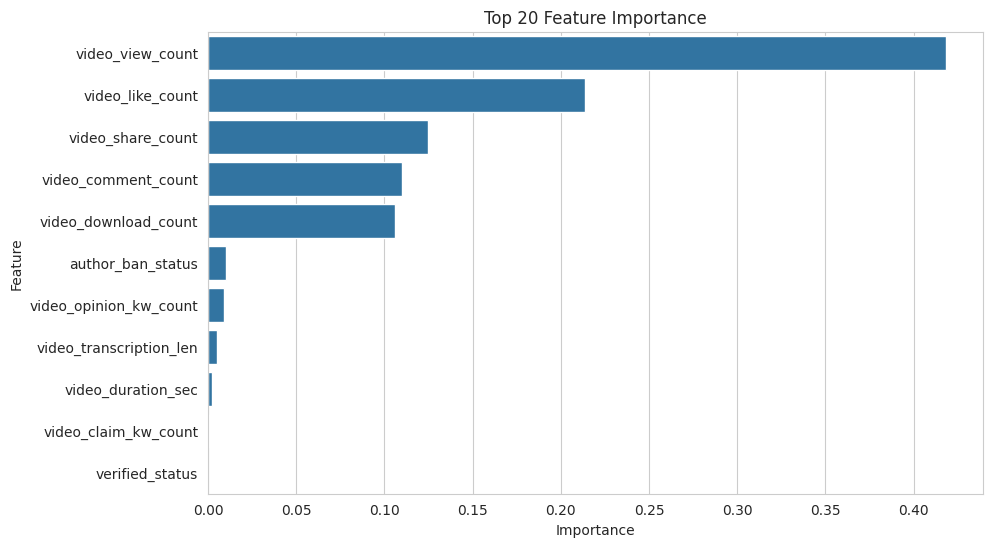

In [46]:
"""

  Done: Generated feature importance plot to discover which as the important features.

"""
# Get feature importance from the classifier
importances = model.feature_importances_

# Get the feature names from the TF-IDF vectorizer
feature_names = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 8: Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))  # Show top 20 features
plt.title('Top 20 Feature Importance')
plt.savefig("rfc_feature_importance_plot.png")
plt.show()

# Feature Importance Analysis

The feature importance plot shows the relative contribution of each feature in the Random Forest Classifier for predicting whether a report is a "claim" or an "opinion."

## Key Observations
1. **Top Features**:
   - **`video_view_count`**: The most critical feature, indicating that higher views significantly influence report classification.
   - **`video_like_count`** and **`video_share_count`**: Highly important, suggesting audience engagement correlates with reporting patterns.

2. **Moderate Features**:
   - **`download_count`** and **`comment_count`**: Contribute moderately, indicating user interaction also plays a role in distinguishing reports.

3. **Low-Impact Features**:
   - **`status_banned`**, **`video_duration_sec`**, and **`verified_status`** have minimal importance, offering little predictive value.

---

## Interpretation
- **Engagement Metrics**:
   - Videos with high engagement (views, likes, shares) may attract opinionated reports due to visibility.
   - Lower engagement videos might be associated with claims, reflecting targeted concerns.

- **Social Behavior**:
   - Features like `comment_count` may represent user discussions linked to opinionated reports, while `download_count` might reflect user interest in controversial content.

- **Irrelevant Features**:
   - Features like `status_banned` may lack variation or relevance to differentiate report types effectively.

---

## Suggestions for improvements

2. **Feature Engineering**:
   - Create new metrics (e.g., `likes/views`, `shares/views`) to capture nuanced engagement patterns.
   - Analyze temporal trends (e.g., spikes in engagement).

3. **Bias Mitigation**:
   - Reliance on engagement metrics may introduce biases (e.g., viral videos skewing predictions). Ensure balanced datasets and explore content-specific features.

---


## 7.2 Logistic Regression

In [47]:
# Initialize the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test)

In [48]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9937
Confusion Matrix:
[[1905   23]
 [   1 1888]]
Classification Report:
              precision    recall  f1-score   support

       claim       1.00      0.99      0.99      1928
     opinion       0.99      1.00      0.99      1889

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



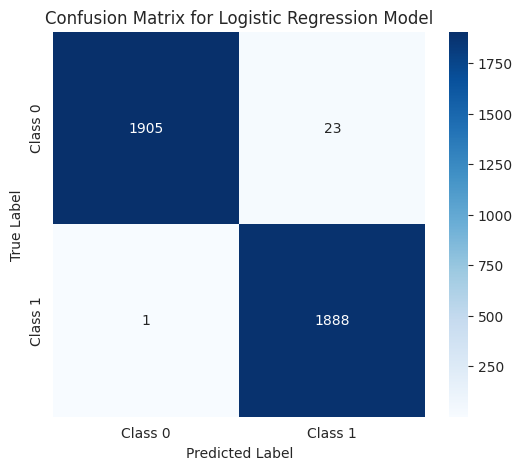

In [49]:
# Visualise confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

True Negatives (TN): 1905 These are the cases where the model correctly predicted not claim (i.e., claim_status = 0)

False Positives (FP): 23 These are the cases where the model incorrectly predicted claim when the true status was not claim

False Negatives (FN): 0 These are the cases where the model incorrectly predicted not claim when the true status was claim

True Positives (TP): 1889 These are the cases where the model correctly predicted claim (i.e., claim_status = 1)

## 7.3 XGBoost Model

Accuracy: 0.9942
Confusion Matrix:
[[1910   18]
 [   4 1885]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1928
           1       0.99      1.00      0.99      1889

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



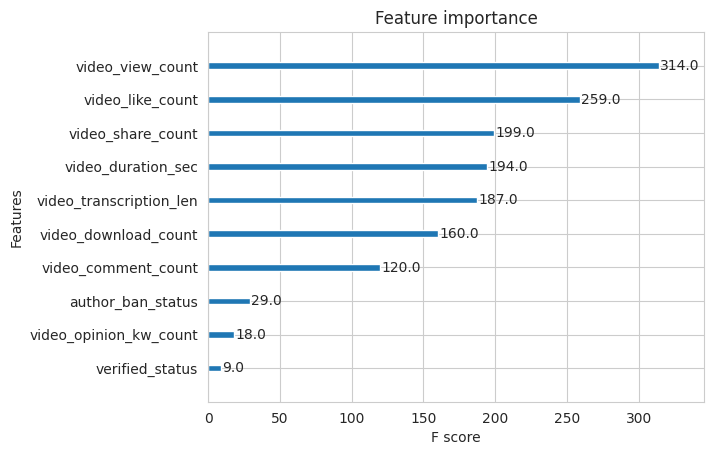

In [50]:
# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the target variable
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test) # Apply the same transformation to y_test

xgb_model = XGBClassifier()

# Now you can train the XGBoost model with the transformed target variable
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot feature importance
plot_importance(xgb_model)
plt.show()

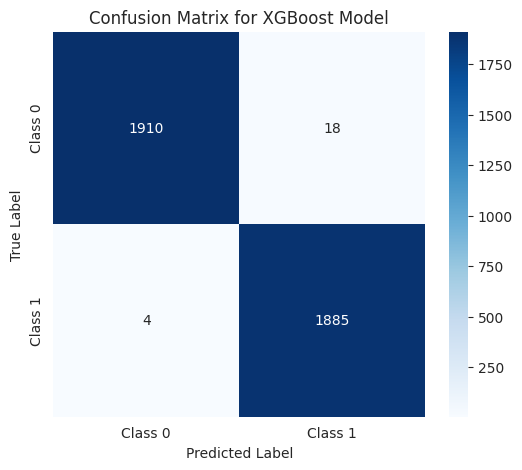

In [51]:
# Confusion matrix for the XGBoost model
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

True Negatives (TN): 1908 These are the cases where the model correctly predicted not claim (i.e., claim_status = 0)

False Positives (FP): 20 These are the cases where the model incorrectly predicted claim when the true status was not claim

False Negatives (FN): 3 These are the cases where the model incorrectly predicted not claim when the true status was claim

True Positives (TP): 1886 These are the cases where the model correctly predicted claim (i.e., claim_status = 1)

## 8. Conclusion